## In this spreadsheet, I will train a UNet CNN to detect buildings in imagery using the [SpaceNet 2 Khartoum training dataset](https://spacenet.ai/spacenet-buildings-dataset-v2/). 

0. Run the preliminary blocks first.
1. Create a dataset object from the training, validation, and test data on Google Drive (in MyDrive/Khartoum), with all the normalization and augmentation you need.
2. Construct the UNet model. 
3. Check what it does before you train it.
4. Train it and check the results.  

### 5 blocks to run for setup.

- mount your google drive
- install Miniconda
- update conda
- set up sys.path so new python installs work
- install geospatial stuff and any other libs you need
- import geospatial projects.

In [34]:
# Mount the drive: THIS NEEDS A USER RESPONSE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Install conda: shell block
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    ------------------------------------------------------------
                                           Total:         2.9 M

--2021-09-28 19:02:11--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh [following]
--2021-09-28 19:02:12--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh.1’

     0K .......... .......... .......... .......... ..........  0% 12.4M 7s
    50K .......... .......... ..........

In [36]:
# Python block: Set up path to python site-packages
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

In [37]:
# shell block: import additional Python libraries
!conda install --channel conda-forge opencv geopandas geojson --yes

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - geojson
    - geopandas
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    krb5-1.19.2                |       hcc1bbae_2         1.4 MB  conda-forge
    ------------------------------------------------------------
                                    

In [38]:
# Python import block
import numpy as np
import cv2
import os
import gdal
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random

### Create a data generator.

First, without augmentation or normalization. That's to add later after I get this working end-to-end.

To have more control over how data is fed in, I'm going to implement a custom DataGenerator. 

First, I grabbed this function 'upsample' from pix2pix.py in this github repo, rather than conda install pip and then pip install the whole repo ... 

In [39]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [40]:
def get_matching_masks_list(images_list, mask_folder):
  '''
  for use in the custom data generator. 
  Given a list of image chips in a certain order,
  check whether each image chip has a matching mask in the mask_folder,
  and construct the matching list of mask filenames.
  '''

  import re
  masks = []
  filenum_pattern = re.compile(r"img(?P<numbers>[0-9]+)\.tif$")
  for filename in images_list:
    chip_match = filenum_pattern.search(filename)
    if chip_match is None:
      print(f"Warning: Found Unexpected Image Filename in images list, skipping it: {filename}")
      continue
    filenum = int(chip_match.group("numbers"))
    matching_maskfile = os.path.join(mask_folder, f"RGB-PanSharpen_AOI_5_Khartoum_mask{filenum}.tif")
    if not os.path.exists(matching_maskfile):
      print(f"Error: Mask File {matching_maskfile} not found")
      raise FileNotFoundError
    masks.append(matching_maskfile)
  return masks



In [41]:
# test the get_matching_masks_list() function

image_base = '/content/drive/MyDrive/Khartoum/train_frames'
mask_base = '/content/drive/MyDrive/Khartoum/train_masks'
training_images = os.listdir(image_base)
training_masks = get_matching_masks_list(training_images, mask_base)

ii = 0
for image, mask in zip(training_images, training_masks):
  print(f"{image} ->> {mask}")
  ii = ii+1
  if ii == 10:
    break

RGB-PanSharpen_AOI_5_Khartoum_img244.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask244.tif
RGB-PanSharpen_AOI_5_Khartoum_img1338.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask1338.tif
RGB-PanSharpen_AOI_5_Khartoum_img147.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask147.tif
RGB-PanSharpen_AOI_5_Khartoum_img1456.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask1456.tif
RGB-PanSharpen_AOI_5_Khartoum_img484.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask484.tif
RGB-PanSharpen_AOI_5_Khartoum_img199.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask199.tif
RGB-PanSharpen_AOI_5_Khartoum_img1574.tif ->> /content/drive/MyDrive/Khartoum/train_masks/RGB-PanSharpen_AOI_5_Khartoum_mask1574.tif
RGB-PanSharpen_AOI_5_Khartoum_img197.tif ->> /content/drive/MyDrive/Khartoum/

In [42]:
import gdal
import osgeo.gdalnumeric as gdn

def gdal_get_tensor(image_path, dtype="float32", dim_ordering="channels_last"):
  '''
  Reads image as a tensor and normalizes it to have values in [-1, 1].
  image_path: path to a gdal-readable color or grayscale image.
  dtype: desired datatype of output tensor
  dim_ordering: "channels_last" (tensorflow standard) or "channels_first" (gdal_standard)
  
  '''
  file  = gdal.Open(image_path)
  bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
  arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)
  # print("MIN: ",np.min(arr))
  # print("MAX: ",np.max(arr))
  # Reorder dimensions, so that channels are last -- standard for tensorflow tensors
  if dim_ordering=="channels_last":
      arr = np.transpose(arr, [1, 2, 0])  
  return arr

In [43]:
# custom DataGenerator
def datagen(img_folder, mask_folder, image_size, batch_size):

  c = 0
  images_list = os.listdir(img_folder) #List of training images
  random.shuffle(images_list)
  # assume you also have a matching list of masks here
  masks_list = get_matching_masks_list(images_list, mask_folder)

  while (True):

    # initialize space for the images and masks in this batch
    img_batch = np.zeros((batch_size, image_size, image_size, 3)).astype('float')
    mask_batch = np.zeros((batch_size, image_size, image_size, 1)).astype('float')

    # put the images and masks into their 4D batch tensors.
    for ii in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

      # Read one image, normalize it, and resize it
      # CJ note 9/27: I'm setting the normalization factor to 2000 to test my theory that normalization problems are causing convergence to fail. 
      # the image values vary, but all seem less than this. 
      train_img = gdal_get_tensor(os.path.join(img_folder, images_list[ii]))/2000.00
      train_img =  cv2.resize(train_img, (image_size, image_size))
      # this adds the image to the image batch, which is a 4-tensor.
      img_batch[ii-c] = train_img #add to array - img[0], img[1], and so on.
                                                   
      # Read one mask, normalize it (? what is the mask value set to? 1!) and resize it
      # when you created these masks, you made them 3-channel by accident -- such a waste of space!
      # work around it!
      train_mask = gdal_get_tensor(masks_list[ii])
      train_mask = cv2.resize(train_mask, (image_size, image_size))
      # The masks are actually not 3-tensors, so we add an extra dimension for parity with train_img dimensions [512 * 512 * 3]
      train_mask = train_mask.reshape(image_size, image_size, 3)

      # keep only the 1st band, which has the data
      # print(np.max(train_mask[:,:,0]))
      # print(np.max(train_mask[:,:,1]))
      # print(np.max(train_mask[:,:,2]))
      train_mask = train_mask[:,:,0]
      train_mask = train_mask.reshape(image_size, image_size, 1)
      mask_batch[ii-c] = train_mask

    # now we've constructed the next image and mask batch.
    # increment the files index by batch_size, and check whether the new c index is greater than the number of files. 
    # if so, reset it to zero and random shuffle the files again.
    c+=batch_size
    if(c+batch_size>=len(images_list)):
      c=0
      random.shuffle(images_list)
                  # print "randomizing again"
    yield img_batch, mask_batch

### Set up the data generator.

First declare the image and batch sizes.

In [44]:
IM_SIZE = 512
BATCH_SIZE = 8

In [45]:
# Try out the custom data generator using Image size 512, batch size 1.
# Note the SN2 chips are 650 x 650 x 3 (RGB)
train_image_base = '/content/drive/MyDrive/Khartoum/train_frames'
train_mask_base = '/content/drive/MyDrive/Khartoum/train_masks'
val_image_base = '/content/drive/MyDrive/Khartoum/val_frames'
val_mask_base = '/content/drive/MyDrive/Khartoum/val_masks'
test_image_base = '/content/drive/MyDrive/Khartoum/test_frames'
test_mask_base = '/content/drive/MyDrive/Khartoum/test_masks'

### Display the output of the DataGenerator. 

OK I finally have it. But the images look awfully green to me. 

Looking at values by band in QGIS, and here, yes, these images are pretty green.

In [46]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    the_array = display_list[i]
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    display_img = tf.keras.preprocessing.image.array_to_img(the_array)
    plt.imshow(display_img)
    plt.axis('off')
    print("--------------------------------------------------------------")
  plt.show()

--------------------------------------------------------------
--------------------------------------------------------------


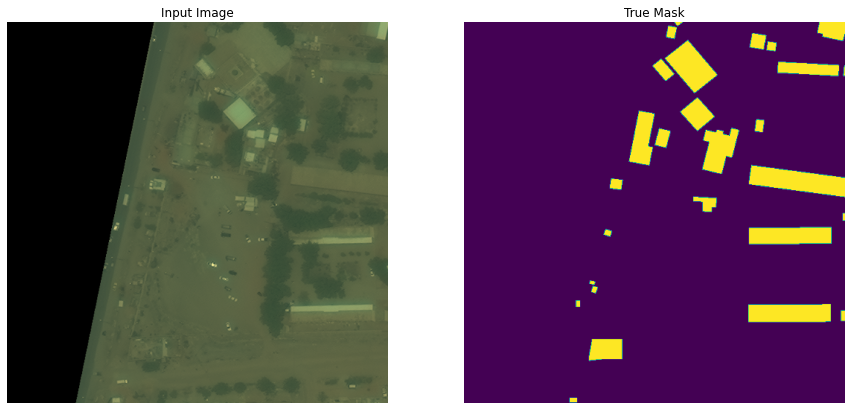

In [47]:
ii = 0
for images, masks in datagen(train_image_base,train_mask_base, IM_SIZE, BATCH_SIZE):
  # print(images)
  # these are 4 tensors where the first dimensions is a batch: so use images[0], masks[0] for display
  display([images[0], masks[0]])
  ii = ii+1
  if ii == 1: 
    break

### Define the UNet model

This model is drawn from the Unet model in Unet_segmentation_example.ipynb. To see more detail, look in that file.

Note that the MobileNet model is complaining because the input spatial dimensions are not in the predefined set of numbers that it likes. In the source example, the input dimensions were in that set. So it is loading weights for the nearest input dimension, which is half the size. So be aware of this -- after you get the model running end to end, you will want to switch out MobileNet for a better-suited encoder!

In [48]:
# define the encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[IM_SIZE, IM_SIZE, 3], include_top=False)


# this has a huge output but is useful if you haven't seen it. 
# tf.keras.utils.plot_model(base_model, show_shapes=True)


In [49]:
# Use the activations of these 5 layers as skip-connection features in the decoder.
# Dimensions of the layers for 512x512 input are shown alongside.
layer_names = [
    'block_1_expand_relu',   # 256x256x96
    'block_3_expand_relu',   # 128x128x144
    'block_6_expand_relu',   # 64x64x192
    'block_13_expand_relu',  # 32x32x576
    'block_16_project',      # 16x16x320
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [50]:
# Create the encoder portion of the model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [51]:
# Note: that first value is the number of channels in the upsampled output. 
# the second value is the size of the convolution filter to apply.
# Alongside are tensor dimensions for 512x512 input.
up_stack = [
    upsample(512, 3),  # 16x16 -> 32x32x512
    upsample(256, 3),  # 32x32 -> 64x64x256
    upsample(128, 3),  # 64x64 -> 128x128x128
    upsample(64, 3),   # 128x128 -> 256x256x64
]

In [52]:
def endl():
  print("\n")

def divider():
  print("============================================================\n")


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IM_SIZE, IM_SIZE, 3])

  # Downsampling through the model
  # down_stack is a model, and therefore is callable with the inputs to the unet.
  # calling it returns the 5 layers that were included in the down_stack definition.
  # skips is a list of 5 items, each of which is a KerasTensor with the 
  # shape determined by the layer.
  skips = down_stack(inputs)

  # this returns the last layer, to initialize the upsampling.
  x = skips[-1]

  # this reverses the order of the layers in skips
  print("layers in down_stack")

  # python note: 'reversed' results in skip becoming an iterator
  # which can be exhausted, like 'zip' does. So call 'list' on it to get 
  # a list which can be iterated over more than once.
  skips = list(reversed(skips[:-1]))
  for layer in skips:
    print(layer)
  divider()

# at this point, 'skips' is a list of layers with shapes (for an input of dimensions 512x512x3):
# (32,32,576), (64,64, 192), (128, 128, 144), (256, 256, 96) (see output from the "Functional" block in the model diagram).
# And 'up_stack' is a list of transforms converting their inputs to shapes:
# (32, 32, 512), (64, 64, 256), (128, 128, 128), (256, 256, 64).
# see the output when this function is run.
# After concatenating, the results are blocks of this size:
# (32, 32, 1088), (64, 64, 448), (128, 128, 272), (256, 256, 160).
# Confirm in the 'concatenate' blocks of the diagram below.


  # This is the heart of the unet
  # Upsampling and establishing the skip connections.
  # Start the iteration with the final feature layer in 'down_stack' 
  # which is (16, 16, 320).
  # The first call in the iteration upsamples it to (32,32, 512).
  # the 3rd call concatenates this to the 1st layer in 'skips' which is (32, 32, 576).
  print("layers produced by the transforms in up_stack")
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x) 
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  divider()

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Compile the model and common sense check dimensions.

In [53]:
OUTPUT_CLASSES = 2 # building and nonbuilding

unet_model_1 = unet_model(output_channels=OUTPUT_CLASSES)
unet_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

layers in down_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 576), dtype=tf.float32, name=None), name='model_3/block_13_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 192), dtype=tf.float32, name=None), name='model_3/block_6_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 144), dtype=tf.float32, name=None), name='model_3/block_3_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 96), dtype=tf.float32, name=None), name='model_3/block_1_expand_relu/Relu6:0', description="created by layer 'model_3'")

layers produced by the transforms in up_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='sequential_4/re_lu_4/Relu:0', description="created by layer 'sequential_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 6

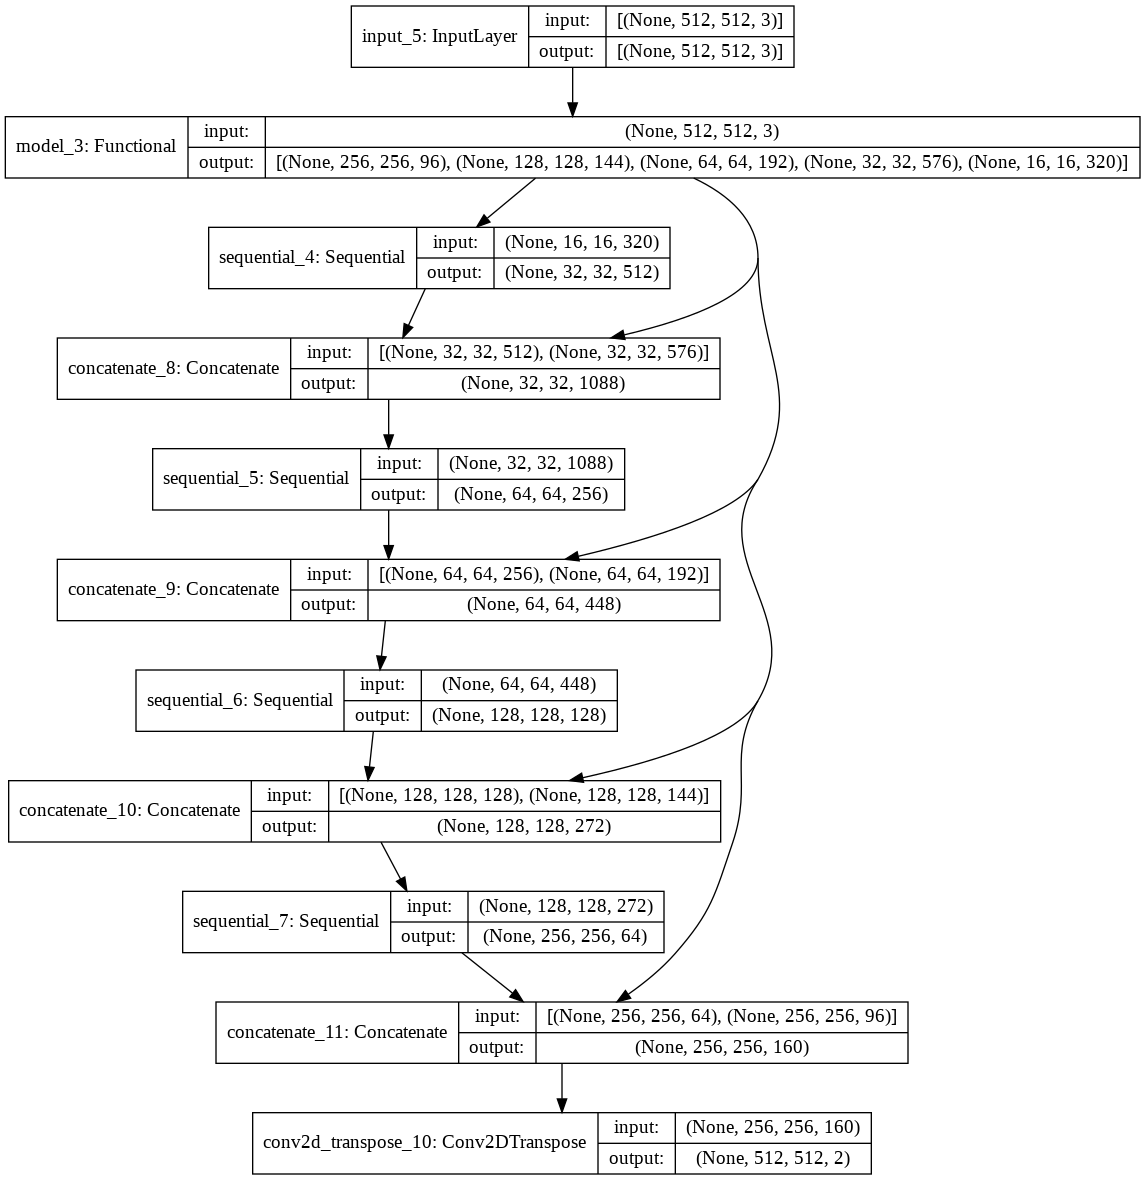

In [54]:
tf.keras.utils.plot_model(unet_model_1, show_shapes=True)

In [55]:
def create_mask(pred_mask):

  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

def show_prediction(image_batch, mask_batch, model):
  pred_batch = model.predict(image_batch)
  for image, mask, pred in zip(image_batch, mask_batch, pred_batch):
    display([image, mask, create_mask(pred)])
  return

### Check what the model does before it is trained. We expect it to be crap, and it is. 

In [56]:
limit = 1
ii = 1
for image, mask in datagen(train_image_base,train_mask_base, IM_SIZE, BATCH_SIZE):
  show_prediction(image, mask, unet_model_1)
  ii=ii+1
  if ii>limit: break

Output hidden; open in https://colab.research.google.com to view.

### Train the model. Look at predictions at the end of every epoch. 

The data generator will keep spitting out samples indefinitely. You need to break it into epochs, and stop it. 

Below is a callback to look at the predictions after each epoch. We expect them to improve.


In [57]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    for image, mask in datagen(test_image_base,test_mask_base, IM_SIZE, BATCH_SIZE):
      show_prediction(image, mask, unet_model_1)
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
      break

In [58]:
training_img_files = os.listdir(train_image_base)
val_img_files = os.listdir(val_image_base)
TRAIN_LENGTH = len(training_img_files)
VAL_LENGTH = len(val_img_files)
BUFFER_SIZE = 1000
# integer rounding down, I think
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [59]:
EPOCHS_1 = 1 # checking only one epoch first
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

# unet_model_1_history = unet_model_1.fit(datagen(train_image_base,train_mask_base, IM_SIZE, BATCH_SIZE), 
#                               epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=datagen(val_image_base,val_mask_base, IM_SIZE, BATCH_SIZE),
#                               callbacks=[DisplayCallback()])

### What's in model_history?

It keeps the metrics history from the training process, saving the training and validation metrics of loss and accuracy after each epoch. Following training for a single epoch, these are lists containing a single element.

Maybe the model object is a pointer to the fitted model? The pointers are the same, so I guess that's the case.

In [60]:
# print(model_history.history.keys())
# print(model_history.history["val_loss"])
# print(model_history.model)
# print(unet_model_1)

## Save the model to disk.

In this section, I'll create and train a new unet model, and save checkpoints.

Here I worked from this tutorial: [Save and Load Models](https://www.tensorflow.org/tutorials/keras/save_and_load).



In [61]:
checkpoint_dir = "/content/drive/MyDrive/unet_train_sgd_bch8_lr02"
if os.path.exists(checkpoint_dir):
  print(f'found {checkpoint_dir}')
  if len(os.listdir(checkpoint_dir)) !=0:
    print(f'Warning: {checkpoint_dir} is not empty')
else:
  print(f'{checkpoint_dir} not found, creating it')
  os.mkdir(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt')

found /content/drive/MyDrive/unet_train_sgd_bch8_lr02


In [62]:
# Note: setting save_freq to an integer causes the checkpoint to be saved after that many batches.
# so setting save_freq=2*batch_size means: save every 2 epochs.
# to save after every epoch set save_freq="epoch", or leave empty as "epoch" is the default

cpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq="epoch") # was: 5*BATCH_SIZE


### Create a new, 2nd unet model and train it with a larger number of epochs.

In [65]:
unet_model_2 = unet_model(output_channels=OUTPUT_CLASSES)
unet_model_2.compile(tf.keras.optimizers.SGD(0.02),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

layers in down_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 576), dtype=tf.float32, name=None), name='model_3/block_13_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 192), dtype=tf.float32, name=None), name='model_3/block_6_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 144), dtype=tf.float32, name=None), name='model_3/block_3_expand_relu/Relu6:0', description="created by layer 'model_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 96), dtype=tf.float32, name=None), name='model_3/block_1_expand_relu/Relu6:0', description="created by layer 'model_3'")

layers produced by the transforms in up_stack
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='sequential_4/re_lu_4/Relu:0', description="created by layer 'sequential_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 6

In [66]:
unet_model_2.save_weights(checkpoint_path.format(epoch=0))

In [67]:
EPOCHS_2 = 6

unet_model_2_history = unet_model_2.fit(
    datagen(train_image_base,train_mask_base, IM_SIZE, BATCH_SIZE), 
    epochs=EPOCHS_2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=datagen(val_image_base,val_mask_base, IM_SIZE, BATCH_SIZE),
    callbacks=[cpt_callback])

Epoch 1/6
88/88 [==============================] - 835s 9s/step - loss: 0.4528 - accuracy: 0.9927 - val_loss: 0.4286 - val_accuracy: 0.9993

Epoch 00001: saving model to /content/drive/MyDrive/unet_train_sgd_bch8_lr02/cp-0001.ckpt
Epoch 2/6
88/88 [==============================] - 834s 9s/step - loss: 0.4539 - accuracy: 0.9969 - val_loss: 0.4427 - val_accuracy: 0.9997

Epoch 00002: saving model to /content/drive/MyDrive/unet_train_sgd_bch8_lr02/cp-0002.ckpt
Epoch 3/6
88/88 [==============================] - 842s 10s/step - loss: 0.4515 - accuracy: 0.9987 - val_loss: 0.3679 - val_accuracy: 0.9999

Epoch 00003: saving model to /content/drive/MyDrive/unet_train_sgd_bch8_lr02/cp-0003.ckpt
Epoch 4/6
88/88 [==============================] - 856s 10s/step - loss: 0.4506 - accuracy: 0.9992 - val_loss: 0.4036 - val_accuracy: 0.9999

Epoch 00004: saving model to /content/drive/MyDrive/unet_train_sgd_bch8_lr02/cp-0004.ckpt
Epoch 5/6
88/88 [==============================] - 828s 9s/step - loss: 0.

---


### Saved stuff 


Below: a generator derived from ImageDataGenerator (i.e., not custom -- so its workings are more mysterious). 

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # Construct ImageDataGenerators.

# train_datagen = ImageDataGenerator(
#         rescale=1./255)        
# val_datagen = ImageDataGenerator(rescale=1./255)


# train_frames = '/content/drive/MyDrive/Khartoum/train_frames'
# train_masks = '/content/drive/MyDrive/Khartoum/train_masks'
# val_frames = '/content/drive/MyDrive/Khartoum/val_frames'
# val_masks = '/content/drive/MyDrive/Khartoum/val_masks'


# # Point at the appropriate directories. Are the image and mask flows guaranteed
# # to correspond correctly?
# train_image_generator = train_datagen.flow_from_directory(
# train_frames,
# batch_size = 4 #NORMALLY 4/8/16/32)

# train_mask_generator = train_datagen.flow_from_directory(
# train_masks,
# batch_size = 4 #NORMALLY 4/8/16/32)

# val_image_generator = val_datagen.flow_from_directory(
# val_frames,
# batch_size = 4 #NORMALLY 4/8/16/32)


# val_mask_generator = val_datagen.flow_from_directory(
# val_masks,
# batch_size = 4 #NORMALLY 4/8/16/32)

# # Zip them together for a unified generator.
# train_generator = zip(train_image_generator, train_mask_generator)
# val_generator = zip(val_image_generator, val_mask_generator)